# Processing the dataset

Partial reproduction of https://github.com/SinaHonari/RCN/

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
import sys
sys.path.insert(0, '../')

# Loading all the keypoints and corresponding image

In [3]:
import matplotlib.patches as patches
import cv2
import copy
import glob

In [4]:
train_files = glob.glob(os.path.join('../data/', 'helen', 'trainset', '**', '*.pts'), recursive=True)
train_files += glob.glob(os.path.join('../data/', 'lfpw', 'trainset', '**', '*.pts'), recursive=True)
train_files += glob.glob(os.path.join('../data/', 'afw', '**', '*.pts'), recursive=True)

print('Found {} train files'.format(len(train_files)))

Found 3148 train files


In [5]:
def read_pts(paths):
    if type(paths) not in (list, set):
        paths = [paths]
    dataset = []
    
    for path in paths:
        with open(path, 'r') as f:
            # skip the version
            f.readline()
            # reading the number of points
            n_points = int(f.readline().split(':')[1].strip())

            keypoints = []
            for line in f.readlines():
                if line.strip() in ('{', '}'):
                    continue

                keypoints.extend([float(l.strip()) for l in line.split()])

            assert len(keypoints)/2 == n_points, '{} says {} points, but {} found'.format(path, n_points, len(keypoints))

            image_path = os.path.splitext(path)[0] + '.jpg'
            if not os.path.isfile(image_path):
                image_path = os.path.splitext(path)[0] + '.png'
                
                if not os.path.isfile(image_path):
                    raise ValueError('Could not find the image related to {}'.format(path))

            dataset.append([image_path] + keypoints)
    
    return pd.DataFrame(dataset)

In [6]:
train_df = read_pts(train_files)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,127,128,129,130,131,132,133,134,135,136
0,../data/helen/trainset/100032540_1.jpg,556.165461,701.817915,558.172491,765.801895,563.041454,828.311918,568.433747,887.335097,570.118682,...,808.671428,881.676925,882.489324,906.275579,808.005244,892.641088,781.653912,896.106504,754.238033,889.796064
1,../data/helen/trainset/100040721_1.jpg,255.817113,295.419501,255.279791,321.113198,257.775072,347.617478,263.511959,373.090866,278.373099,...,371.478208,354.863325,393.160148,367.247435,369.701500,368.908887,354.183906,369.275473,339.660869,366.684961
2,../data/helen/trainset/100040721_2.jpg,215.338071,280.960156,222.118134,310.192139,230.554929,341.340589,239.060184,363.679567,251.307299,...,366.159317,335.393645,377.372212,350.872472,364.424885,348.716739,351.895005,348.193577,341.989787,346.238179
3,../data/helen/trainset/1002681492_1.jpg,311.294220,279.806271,306.490593,315.571807,308.042443,357.480813,317.415944,396.693232,331.544970,...,491.870134,398.630064,518.959380,414.862707,491.870134,398.630064,479.276471,396.996011,466.339113,395.654667
4,../data/helen/trainset/1004467229_1.jpg,212.041509,113.718439,207.950332,137.626689,206.616210,161.056077,205.011559,182.765269,204.408662,...,272.297269,203.294910,296.529947,214.463530,269.164300,210.795318,258.948774,208.621167,251.015609,205.733351


### Visualizing some images and the keypoints

In [7]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    
    if isinstance(image, str):
        image = io.imread(image)
        
    plt.imshow(image)
        
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

0 ../data/helen/trainset/146623854_1.jpg (68, 2)
1 ../data/helen/trainset/2527422664_1.jpg (68, 2)
2 ../data/lfpw/trainset/image_0549.png (68, 2)


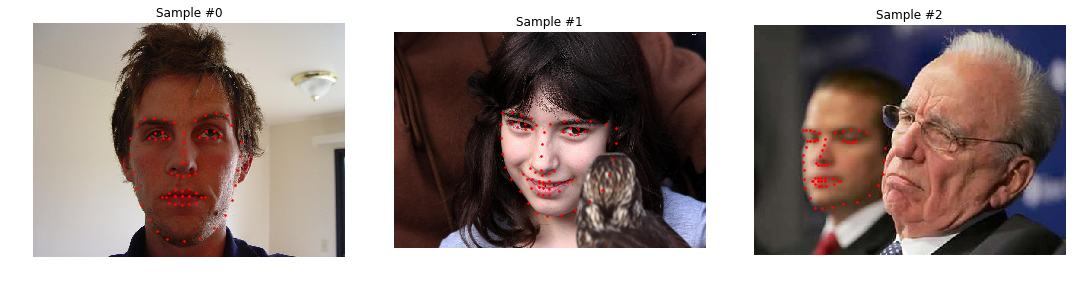

In [8]:
N = 3

plt.figure(figsize=(20,20))
for i in range(N):
    
    idx = np.random.randint(len(train_df))
    
    image = train_df.ix[idx,0]
    landmarks = train_df.ix[idx, 1:].as_matrix().astype('float').reshape((-1, 2))

    print(i, image, landmarks.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(image, landmarks)


### Extracting the bounding box

In [9]:
def get_bbox(x1, y1, x2, y2):
    """ Extracts a square bound box given the coordinates
    """
    
    x_start = int(np.floor(x1))
    x_end = int(np.ceil(x2))
    y_start = int(np.floor(y1))
    y_end = int(np.ceil(y2))
    
    width = np.ceil(x_end - x_start)
    height = np.ceil(y_end - y_start)
    
    # Checks if the box is square
    if width < height:
        diff = height - width
        x_start -=(np.ceil(diff/2.0))
        x_end +=(np.floor(diff/2.0))
        
    elif width > height:
        diff = width - height
        y_start -=(np.ceil(diff/2.0))
        y_end +=(np.floor(diff/2.0))
        
    
    width = x_end - x_start
    height = y_end - y_start
    assert width == height
    
    rect_init_square = [int(x_start), int(y_start), int(width), int(height)]
    max_margin = 0

    return (rect_init_square, max_margin)

In [10]:
def get_bbox_from_landmarks(landmarks):
    x_min = np.min(landmarks[:, 0])
    y_min = np.min(landmarks[:, 1])
    x_max = np.max(landmarks[:, 0])
    y_max = np.max(landmarks[:, 1])
    
    return get_bbox(x_min, y_min, x_max, y_max)

### Printing images with the bounding box

0 ../data/helen/trainset/2741148975_1.jpg (68, 2)
1 ../data/helen/trainset/1861796452_1.jpg (68, 2)
2 ../data/helen/trainset/1271089376_2.jpg (68, 2)


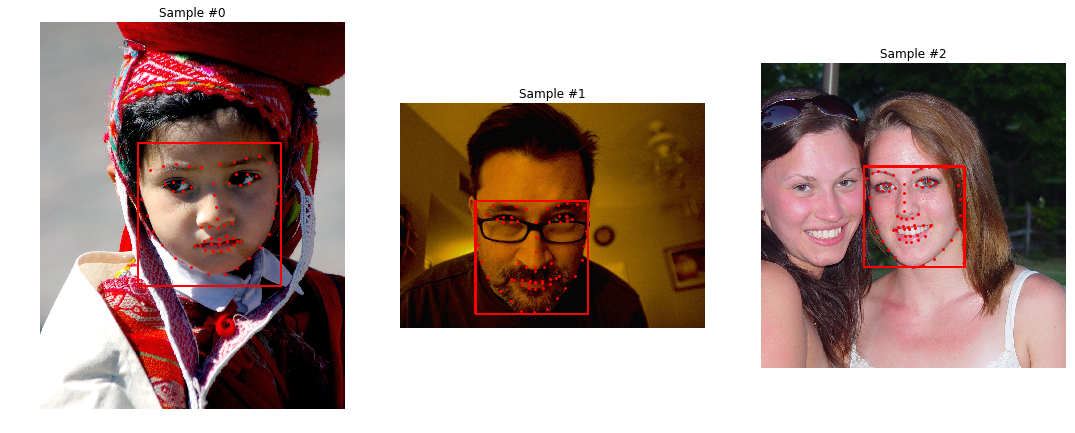

In [11]:
N = 3

plt.figure(figsize=(20,20))
for i in range(N):
    
    idx = np.random.randint(len(train_df))
    
    image = train_df.ix[idx,0]
    landmarks = train_df.ix[idx, 1:].as_matrix().astype('float').reshape((-1, 2))
    
    bbox, _ = get_bbox_from_landmarks(landmarks)

    print(i, image, landmarks.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(image, landmarks)
    
    x_start, y_start, width, height = bbox
    
    rect_img = cv2.rectangle(cv2.imread(image),(x_start, y_start), (x_start + width, y_start + height), (0, 0, 255), 10)
    
    show_landmarks(cv2.cvtColor(rect_img, cv2.COLOR_BGR2RGB), landmarks)


### Printing images with the expanded bounding box

In [12]:
def enlarge_bbox(bbox, ratio=1.25):
    x_start, y_start, width, height = bbox
    
    x_end = x_start + width
    y_end = y_start + height
    
    assert width == height, "width %s is not equal to height %s" %(width, height)
    assert ratio > 1.0 , "ratio is not greater than one. ratio = %s" %(ration,)
    
    change = ratio - 1.0
    
    shift = (change/2.0)*width
    
    x_start_new = int(np.floor(x_start - shift))
    x_end_new = int(np.ceil(x_end + shift))
    y_start_new = int(np.floor(y_start - shift))
    y_end_new = int(np.ceil(y_end + shift))

    # assertion for increase lenght
    width = int(x_end_new - x_start_new)
    height = int(y_end_new - y_start_new)
    
    assert height == width
    
    max_margin = 0
    rect_init_square = [x_start_new, y_start_new, width, height]
    
    return (rect_init_square , max_margin)

0 ../data/lfpw/trainset/image_0193.png (68, 2)
1 ../data/helen/trainset/1045890692_1.jpg (68, 2)
2 ../data/helen/trainset/1571181976_1.jpg (68, 2)


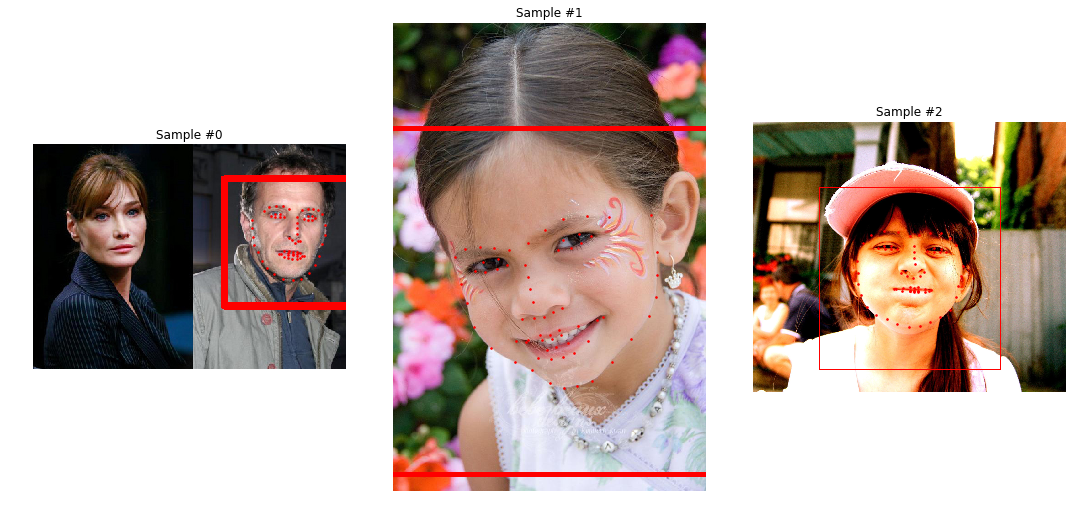

In [13]:
N = 3

plt.figure(figsize=(20,20))
for i in range(N):
    
    idx = np.random.randint(len(train_df))
    
    image = train_df.ix[idx,0]
    landmarks = train_df.ix[idx, 1:].as_matrix().astype('float').reshape((-1, 2))
    
    bbox, _ = get_bbox_from_landmarks(landmarks)
    
    rect, _ = enlarge_bbox(bbox, ratio=1.7)

    print(i, image, landmarks.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    x_start, y_start, width, height = rect
    
    rect_img = cv2.rectangle(cv2.imread(image),(x_start, y_start), (x_start + width, y_start + height), (0, 0, 255), 10)
    
    show_landmarks(cv2.cvtColor(rect_img, cv2.COLOR_BGR2RGB), landmarks)
    


### Verify if the expanded bbox preserves the images boundaries

In [14]:
x_min = np.min(landmarks[:, 0])
y_min = np.min(landmarks[:, 1])
x_max = np.max(landmarks[:, 0])
y_max = np.max(landmarks[:, 1])

In [15]:
x_start, y_start, width, height = rect
x_end = x_start + width
y_end = y_start + height

assert x_start < x_min, "x_start %s is not smaller than x_min %s" %(x_start, x_min)
assert x_end > x_max, "x_end %s is not bigger than x_max %s" %(x_end, x_max)
assert y_start < y_min, "y_start %s is not smaller than y_min %s" %(y_start, y_min)
assert y_end > y_max, "y_end %s is not bigger than y_max %s" %(y_end, y_max)

## Loading image with open cv

In [16]:
from PIL import Image
import cv2

In [17]:
idx = 166

In [18]:
image = train_df.ix[idx,0]
landmarks = train_df.ix[idx, 1:].as_matrix().astype('float').reshape((-1, 2))
bbox, _ = get_bbox_from_landmarks(landmarks)
rect, _ = enlarge_bbox(bbox)

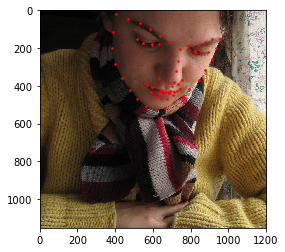

In [19]:
show_landmarks(image, landmarks)

In [20]:
img = Image.open(image)
img_width, img_height = img.size
[img_width, img_height]

[1200, 1154]

In [21]:
# in order to convert PIL image to cv2 format, the image should be converted to RGB first
img_rgb = img.convert('RGB')

In [22]:
# getting the numpy array from image, this numpy array is in RGB format
img_npy=np.asarray(img_rgb)

In [23]:
# cv2 images are in BGR fortmat, so RGB should be changed to BGR
if len(img_npy.shape) == 3:
    img_npy = img_npy[:, :, ::-1].copy()
# if the image is in gray-scale convert it to BGR
elif len(img_npy.shape) == 2:
    img_npy = cv2.cvtColor(img_npy, cv2.COLOR_GRAY2BGR)

#### Increase the image size if the bbox is outside of the image

In [24]:
def increase_img_size(img, bbox):
    """ this method increases the bounding box size
    if start and end values for the bounding box
    go beyond the image size (from either side)
    and in such a case gets the ratio of padded region
    to the total image size (total_img_size = orig_size + pad)
    """ 
    x_start, y_start, width_bbox, height_bbox = bbox
    x_end = x_start + width_bbox
    y_end = y_start + height_bbox
    
    height, width, _ = img.shape

    x_extra_start = 0
    x_extra_end = 0
    y_extra_start = 0
    y_extra_end = 0

    if x_start < 0:
        x_extra_start = - x_start
    if x_end > width:
        x_extra_end = x_end - width
    if y_start < 0:
        y_extra_start = - y_start
    if y_end > height:
        y_extra_end = y_end - height
        
    expand_img = cv2.copyMakeBorder(img, y_extra_start, y_extra_end, 
                                    x_extra_start, x_extra_end, cv2.BORDER_CONSTANT, value=0)
    

    # checking bounding box size after image padding
    height, width, _ = expand_img.shape
    
    if x_extra_start:
        x_start = 0
        x_end += x_extra_start
    if y_extra_start:
        y_start = 0
        y_end += y_extra_start
    if x_extra_end:
        x_end = width
    if y_extra_end:
        y_end = height
        
    bbox_width = x_end - x_start
    bbox_height = y_end - y_start
    
    assert bbox_width == bbox_height

    expanded_rect = [x_start, y_start, bbox_width, bbox_height]

    return expand_img, expanded_rect, x_extra_start, y_extra_start

In [25]:
#increasing the image size
img_npy, rect, x_extra_start, y_extra_start = increase_img_size(img_npy, rect)

x_start, y_start, width, height = rect

x_end = x_start + width
y_end = y_start + height
img_height, img_width, _ = img_npy.shape

if x_extra_start:
    landmarks[:,0] += x_extra_start
if y_extra_start:
    landmarks[:,1] += y_extra_start

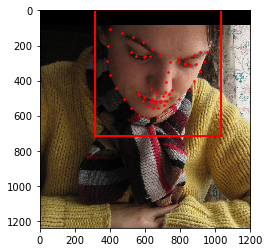

In [26]:
# converting from BGR to RGB
img_RGB = img_npy[:, :, ::-1].copy()
# making sure values are uint8
img_RGB=np.uint8(img_RGB)

rect_img = cv2.rectangle(img_RGB, (x_start, y_start), (x_start + width, y_start + height), (255, 0, 0), 10)
show_landmarks(rect_img, landmarks)

### Cropping the image arround the bounding box

In [27]:
cropped_img = img_npy[y_start:(y_start+height), x_start:(x_start+width), :]
cropped_landmarks = landmarks
cropped_landmarks[:, 0] -= x_start
cropped_landmarks[:, 1] -= y_start

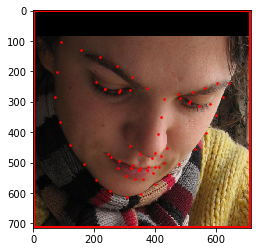

In [28]:
# converting from BGR to RGB
img_RGB = cropped_img[:, :, ::-1].copy()
# making sure values are uint8
img_RGB=np.uint8(img_RGB)

rect_img = cv2.rectangle(img_RGB, (0, 0), (0 + width, 0 + height), (255, 0, 0), 10)
show_landmarks(rect_img, cropped_landmarks)

### Downsampling the images

In [29]:
downsampled_img = cv2.resize(cropped_img, (256, 256), interpolation = cv2.INTER_CUBIC)
normalized_landmarks = cropped_landmarks
normalized_landmarks[:, 0] /= width
normalized_landmarks[:, 1] /= height

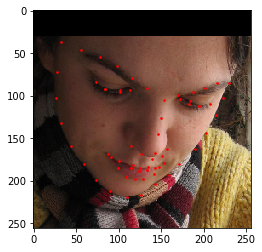

In [30]:
# converting from BGR to RGB
img_RGB = downsampled_img[:, :, ::-1].copy()
# making sure values are uint8
img_RGB=np.uint8(img_RGB)

# rect_img = cv2.rectangle(img_RGB, (0, 0), (0 + width, 0 + height), (255, 0, 0), 10)
show_landmarks(img_RGB, normalized_landmarks*256)

## Doing the same preprocesing from CropFace class

In [31]:
from cpe775.transforms import CropFace

In [32]:
crop_face = CropFace(enlarge_ratio=1.7)

In [33]:
image = Image.fromarray(io.imread(train_df.ix[idx,0]))
landmarks = train_df.ix[idx, 1:].as_matrix().astype('float').reshape((-1, 2))

In [34]:
sample = crop_face({'image': image, 'landmarks': landmarks})

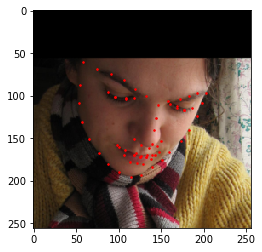

In [35]:
show_landmarks(sample['image'], sample['landmarks']*256)

### Using the dataloader

In [36]:
from cpe775.dataset import FaceLandmarksDataset
from cpe775.transforms import ToTensor
from torchvision import utils
from torch.utils.data import DataLoader

In [37]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched, normalized=True):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy()*im_size + i * im_size,
                    landmarks_batch[i, :, 1].numpy()*im_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

In [38]:
transformed_dataset = FaceLandmarksDataset(csv_file='../data/train.csv',
                                           root_dir='../data/',
                                           transform=transforms.Compose([
                                               CropFace(enlarge_ratio=1.7),
                                               ToTensor()
                                           ]))

NameError: name 'transforms' is not defined

In [ ]:
dataloader = DataLoader(transformed_dataset, batch_size=1,
                        shuffle=True, num_workers=4)

In [ ]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

### Calculating the loss

In [ ]:
from cpe775.criterion import RMSELoss

In [ ]:
loss = RMSELoss()

In [ ]:
image, landmarks = sample_batched['image'][:1], sample_batched['landmarks'][:1]

In [ ]:
loss(landmarks, landmarks).data

#### Calculating the intra-ocular distance

In [ ]:
left_eye_outer_corner = 36
right_eye_outer_corner = 45

In [ ]:
landmarks.shape

In [ ]:
outer_eye = landmarks.numpy()[0, [36, 45], :]

In [ ]:
show_landmarks(image.numpy()[0, ...].transpose(1,2,0), outer_eye*256)

### Visualizing all train data

In [ ]:
dataloader = DataLoader(transformed_dataset, batch_size=32,
                        shuffle=True, num_workers=4)
for i_batch, sample_batched in enumerate(dataloader):

    plt.figure(figsize=(20,6))
    show_landmarks_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()